In [1]:
import qutip as qt
import numpy as np
import matplotlib.pyplot as plt
import scqubits as scq
import pandas as pd
from matplotlib.animation import FuncAnimation
import scipy.constants as sconst

%matplotlib widget

In [2]:
ratio = 100
Ec = 0.25
Ej = Ec*ratio
N = 10 # number of levels in charge basis
ng = 0.5

T_max = 250
T1 = 50
T2 = 400

P0=0.99
R0 = 2.5 * np.pi

def hamiltonian(Ec, Ej, N, ng):
    """
    Return the charge qubit hamiltonian as a Qobj instance.
    """
    m = np.diag(4 * Ec * (np.arange(-N,N+1)-ng)**2) + 0.5 * Ej * (np.diag(-np.ones(2*N), 1) + 
                                                               np.diag(-np.ones(2*N), -1))
                                                               
    return qt.Qobj(m)

def Hc(Ec, N, ng):
    
    m = np.diag(4 * Ec * (np.arange(-N,N+1)-ng)**2) 
    
    return qt.Qobj(m)

def Hj(Ej, N, ng):
    
    m = 0.5 * Ej * (np.diag(-np.ones(2*N), 1) + np.diag(-np.ones(2*N), -1))
    
    return qt.Qobj(m)

H_c = Hc(Ec=Ec, N=N, ng = ng)
H_j = Hj(Ej=Ej, N=N, ng=ng)

H_tot = hamiltonian(Ec, Ej, N, ng)
def EJ_tanh_pulse(t, P0, R0, T):
    return (1-P0*(1+np.tanh(-R0+(t/T)*2*R0))/2.0)

def EJ_double_pulse(t, P0, R0, T1, T2):
    return EJ_tanh_pulse(t, P0, R0, T1) + (EJ_tanh_pulse(t - T2, -P0, R0, T1) - 1)

# Time depenedent part (drive) of Hamiltonian



def Hd_coeff(t,args):
    Percentage=args['P0']
    Range=args['R0']
    T1=args['T1']
    T2=args['T2']
    return EJ_double_pulse(t, Percentage, Range, T1, T2)

def plot_energies(ng_vec, energies, ymax=(20, 3)):
    """
    Plot energy levels as a function of bias parameter ng_vec.
    """
    fig, axes = plt.subplots(1,2, figsize=(10,6))

    for n in range(len(energies[0,:])):
        axes[0].plot(ng_vec, energies[:,n])
    axes[0].set_ylim(-2, ymax[0])
    axes[0].set_xlabel(r'$n_g$', fontsize=18)
    axes[0].set_ylabel(r'$E_n$', fontsize=18)

    for n in range(len(energies[0,:])):
        axes[1].plot(ng_vec, (energies[:,n]-energies[:,0]))
    axes[1].set_ylim(-0.1, ymax[1])
    axes[1].set_xlabel(r'$n_g$', fontsize=18)
    axes[1].set_ylabel(r'$(E_n-E_0)/(E_1-E_0)$', fontsize=18)
    return fig, axes

evs = H_tot.eigenstates()[1]
energy_basis = np.empty((2*N+1, 2*N+1))
i = 0
for ev in evs:
    energy_basis[:, i] = np.array(ev).flatten()
    i+=1
energy_basis = qt.Qobj(energy_basis)
energy_basis_inv= energy_basis.inv()

# M_energy_basis = energy_basis * M_charge_basis * energy_basis_inv


 C:\Users\vamsi\AppData\Local\Temp\ipykernel_12756\4116036815.py: 79

In [3]:
Points=10000
tlist = np.linspace(0, T_max, Points)
H_tot_tdep = [H_c, [H_j, Hd_coeff]]
evals, ekets = H_tot.eigenstates()

psi0 = ekets[0]

se_out =  qt.sesolve(H_tot_tdep, psi0, tlist, args={'P0':P0, 'R0':R0, 'T1':T1, 'T2':T2}, progress_bar=True)

Ovrlp0=np.zeros(Points)
for n in range(0,Points):
   Ovrlp0[n]=np.abs(psi0.dag().overlap(se_out.states[n]))**2
   print(Ovrlp0[n])

10.0%. Run time:   0.63s. Est. time left: 00:00:00:05
20.0%. Run time:   0.82s. Est. time left: 00:00:00:03
30.0%. Run time:   0.99s. Est. time left: 00:00:00:02
40.0%. Run time:   1.22s. Est. time left: 00:00:00:01
50.0%. Run time:   1.44s. Est. time left: 00:00:00:01
60.0%. Run time:   1.66s. Est. time left: 00:00:00:01
70.0%. Run time:   1.89s. Est. time left: 00:00:00:00
80.0%. Run time:   2.10s. Est. time left: 00:00:00:00
90.0%. Run time:   2.36s. Est. time left: 00:00:00:00
Total run time:   2.62s
1.0000000000000004
1.0
1.0
1.0
0.9999999999999993
0.9999999999999987
0.999999999999998
0.9999999999999973
0.9999999999999969
0.9999999999999967
0.9999999999999969
0.9999999999999967
0.9999999999999971
0.999999999999998
0.9999999999999984
0.9999999999999991
0.9999999999999993
0.9999999999999996
0.9999999999999998
1.0
1.0
0.9999999999999998
0.9999999999999991
0.9999999999999989
0.9999999999999978
0.9999999999999971
0.9999999999999962
0.9999999999999956
0.9999999999999956
0.99999999999999

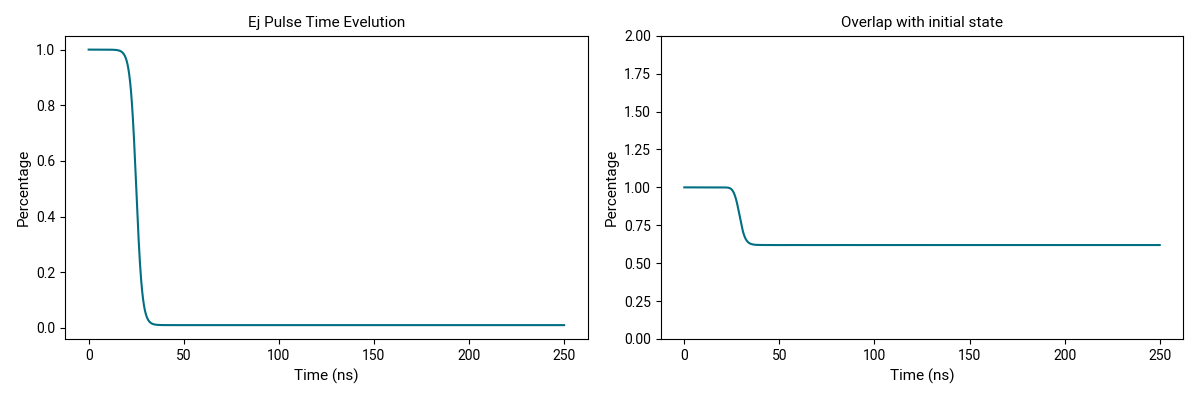

In [6]:
plt.close()
fig, ax = plt.subplots(1, 2, figsize= (12,4))
ax[1].plot(tlist, Ovrlp0)
ax[1].set_xlabel("Time (ns)")
ax[1].set_ylabel("Percentage")
ax[1].set_title("Overlap with initial state")
ax[1].set_ylim(0, 1.1)
ax[0].plot(tlist, Hd_coeff(tlist, args={'P0':P0, 'R0':R0, 'T1':T1, 'T2':T2}))
ax[0].set_xlabel("Time (ns)")
ax[0].set_ylabel("Percentage")
ax[0].set_title("Ej Pulse Time Evelution")
fig.tight_layout()
plt.show()